# Prediction Problem 3

In [243]:
#Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from scipy import stats
import statsmodels.api as sm

### Question 3: Estimating the minimum necessary size of a sensor network

#### Problem statement

*How many sensors would it take to reliably predict CH$_4$ at the facility level across the state?*

In Question 2, we saw that our model was able to predict CH$_4$ at the emitting-facility level to a [moderate] degree of accuracy. Keep in mind, though, that we were making predictions only for the single points in time for which we had AVIRIS plume observations. This can tell us in a loose sense who some of the largest emitters are, if we assume approximately uniform emissions persistence over time, but it doesn't help us understand at all what the true persistence might be. Nor does it give us enough information to estimate longer-term trends, such as total CH$_4$ emissions per year in a county or across the state. For that, it would be useful to be able to collect fine-scale in situ sensor observations at regular time intervals; for that, we would need a continuous network like the AirNow or PurpleAir networks that currently measure particulate matter. 

In a resource-unlimited world, such a network would include a sensor installed at every one of the state's ~270,000 known and suspected CH$_4$ emitting facilities. But sensors being expensive, installation and maintenance time-consuming, and resources limited, we'll have to settle for a smaller set of sensors. 

Given what we now know about the potential for our model to predict CH$_4$ at the facility level, another interesting question we can ask is: What would be the minimum size of a CH$_4$ sensor network required to make accurate facility-level predictions of CH$_4$ emissions across the state?

To approach this question, we created a modeling framework that considered each point in our dataset as a potential sensor-installation location and tested to see how many sensors, randomly distributed across the state, would be required to predict CH$_4$ emissions to a specified error tolerance. The framework begins by training and testing our regression models on a small subset of points (n = 1000) and then increasing the number of observations iteratively (n + a). At each step, we calculate MSE and select the smallest sample size that returns an MSE within 90% of the MSE on the best model from Problem 2.

### Import the dataset >> Michelle you can skip this if it's already loaded for Step 2

In [3]:
datadir = os.sep.join(['/Volumes/Brain/GIS/ER131/Project/Data'])
target_features = os.sep.join([datadir,'target_and_features.geojson'])
df = gpd.read_file(target_features)

#### Step 1. Select and standardize the final response and feature sets
To approach an answer to this question, we operated on the same primary dataframe. To generate the feature set, we again dropped the response and a few other columns that we didn't want passing into the prediction. These included Vista-ID, geometry, and two of the one-hot-encoded categorical columns. Then we generated a standardized set of features for Ridge and Lasso. 

In [7]:
# Show the dataframe again
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head(5)

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,weighted_cow_density,LULC_open_water_perc,LULC_ice_snow_perc,LULC_developed_open_space_perc,LULC_developed_low_int_perc,LULC_developed_med_int_perc,LULC_developed_high_int_perc,LULC_barren_land_perc,LULC_deciduous_forest_perc,LULC_evergreen_forest_perc,LULC_mixed_forest_perc,LULC_shrub_scrub_perc,LULC_grassland_herbaceous_perc,LULC_pasture_hay_perc,LULC_cultivated_crops_perc,LULC_woody_wetlands_perc,LULC_emergent_herbaceous_wetlands_perc,LULC_total_perc,LULC_majority_class,LULC_Barren.Land,LULC_Cultivated.Crops,LULC_Dev..Low.Int,LULC_Dev..Med.Int,LULC_Dev..Open.Space,LULC_Evergreen.Forest,LULC_Grassland,LULC_Herbaceous.Wetlands,LULC_Mixed.Forest,LULC_Open.Water,LULC_Pasture.Hay,LULC_Shrub.Scrub,EmitterType_Composting.Sites,EmitterType_Compressed.Natural.Gas.Fueling.Station,EmitterType_Dairy,EmitterType_Digester,EmitterType_Feed.Lot,EmitterType_Landfill,EmitterType_Liquefied.Natural.Gas.Fueling.Station,EmitterType_Natural.Gas.Processing.Plants,EmitterType_Natural.Gas.Station,EmitterType_Natural.Gas.Storage.Field,EmitterType_Oil.and.Gas.Facility.Boundary,EmitterType_Oil.and.Gas.Field.Boundary,EmitterType_Oil.and.Gas.Well,EmitterType_Power.Plant,EmitterType_Refinery,EmitterType_Wastewater.Treatment.Plant,NearestNeighbor,NN_Distance_m,NN_Type,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry
0,DAF001852,152.0039,2016-09-11,835.7500,807.4955,6392.1007,7391.6466,16539.2553,57707.9384,667538.8408,80.0790,0.0219,0,0.0268,0.0144,0.0112,0.0023,0.0028,0.0,0.000004,0.0,0.0043,0.2347,0.0581,0.6223,0.0006,0.0006,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,DAF000658,2466.0455,Dairy,9,0.0,2.7501,0.3199,"MULTIPOLYGON (((-82488.739 -16790.579, -82489...."
1,DAF001876,111.8814,2016-09-12,1670.0000,1187.6365,85884.6586,94127.2287,127492.1839,170899.8068,842878.1810,1.9753,0.0000,0,0.0363,0.0160,0.0064,0.0020,0.0608,0.0,0.000000,0.0,0.8519,0.0070,0.0011,0.0169,0.0015,0.0001,1,Shrub Scrub,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,COM000219,781.9825,Natural Gas Station,9,0.0,2.7094,0.4187,"MULTIPOLYGON (((260247.391 -342212.585, 260246..."
2,DAF001759,244.1223,2016-09-12,3346.0000,5192.0938,18873.8279,21161.2918,29954.3051,43939.1783,334243.8826,84.3651,0.0021,0,0.0418,0.0125,0.0089,0.0010,0.0008,0.0,0.000000,0.0,0.0009,0.1344,0.0111,0.7862,0.0000,0.0001,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,DAF000910,4638.2693,Dairy,9,0.0,2.6972,0.3413,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1..."
3,DAF001767,112.7884,2016-09-12,1114.6667,799.1323,0.0000,0.0000,0.0000,6753.5702,336951.9840,85.9532,0.0031,0,0.0241,0.0169,0.0157,0.0033,0.0035,0.0,0.000000,0.0,0.0002,0.0517,0.0230,0.8564,0.0003,0.0017,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,OGW166989,1181.9761,Oil and Gas Well,9,0.0,2.6981,0.3361,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9..."
4,DAF001776,105.4107,2016-09-12,1216.2727,814.9383,0.0000,0.0000,0.0000,0.0000,264800.5901,88.5698,0.0040,0,0.0478,0.0263,0.0217,0.0032,0.0033,0.0,0.000000,0.0,0.0002,0.0603,0.0044,0.8274,0.0005,0.0009,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,FDL000024,1901.1757,Feed Lot,9,0.0,2.7004,0.3429,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1..."



First we defined the y column and the features we'd like to drop from the big dataframe.

In [9]:
y_col = 'CH4_Mass_kg'
cols_to_drop = [
    'Vista_ID', 
    'AVIRIS_CH4_median_ppmm', 
    'AVIRIS_CH4_median_date', 
    'AVIRIS_CH4_pxcount', 
    'CH4_Mass_kg', 
    'LULC_majority_class', 
    'LULC_Shrub.Scrub',
    'EmitterType_Wastewater.Treatment.Plant', 
    'NearestNeighbor', 
    'NN_Type', 
    'aviris_month', 
    'geometry']

The standardization function below is a minor modification to the one used in Problem 2. It returns a y vector, a standardized version of the final feature set X, and a raw version of the final feature set X. The standardized X is applied in the next function for Ridge and Lasso regressions, while raw X is applied for OLS.

In [10]:
def get_X_Xstd_y(df, cols_to_drop, y_col):
    '''
    This function returns the raw and standardized X values (features) and y values (response) for regression.
    Input: df, a pd dataframe with all of the fields in the main dataset; 
        - cols_to_drop, strings of the columns to drop from df to select the feature variables
        - y_col, a column name (as a string) of df that represents the response variable
    Returns: three dataframes, X, X_std, y, containing raw features, standardized features, and response
    '''
    
    # drop columns
    y = df[[y_col]]
    X = df.drop(columns = cols_to_drop)

    # use a standard scaler to standardize
    scaler = StandardScaler() # Initialize the StandardScaler
    scaler.fit(X) # Fit the standard scaler for each feature
    X_std = scaler.transform(X) # Standardize each feature
    
    return X, X_std, y

In [ ]:
#Create a function  that fits a linear regression model and returns the training and test MSE. 
def OLS(X_train, y_train, X_test, y_test):
    """ Fits an Ordinary Least Squares Linear regression on the training set of X and y,
    and finds the MSE of the training and test set. 
    Arguments:
        X_train: An ndarray containing the set of features used to train the model. 
        y_train: A list/array containing containing the set of response variable observations used to train the model.
        X_test: An ndarray containing the set of features used to test the model.
        y_test: A list/array containing the set of response variable observations used to test the model. 
    Returns:
        train_mse: the MSE for the training data
        test_mse: The MSE for the test data
        model_coef: The coefficients for the model
        """
    #Fit model
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, lm.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, lm.predict(X_test))
    
    return train_mse, test_mse

In [ ]:
#Define model for Ridge and Lasso Cross Validation
def fit_model_cv(Model, X_train, y_train, X_test, y_test, kf, alphas):
    """Fits a Ridge or Lasso model with K-fold cross-validation on the training set of X and y, 
    and finds the MSE of the training and test set. 
    Arguments:
        Model: The type of Model to use, RidgeCV or LassoCV.
        X_train: An ndarray containing the set of features used to train the model.
        y_train: A list/array containing the set of response variable observations used to train the model. 
        X_test: An ndarray containing the set of features used to test the model. 
        y_test: A list/array containing the set of response variable observations used to test the model. 
        kf: a KFold cross-validation selector object.
            [Note: This should have n_splits, shuffle, and random_state specified]. 
        alphas: a list of alpha values to test during the cross-validation process
    Returns:
        train_mse: the MSE for the training data
        test_mse: the MSE for the test data
        opt_alpha: the optimal alpha value"""
    
    #Fit model
    if Model == LinearRegression:
        modelcv = Model(cv = kf)
    
    else:
        modelcv = Model(cv = kf, alphas = alphas)
    modelcv.fit(X_train, y_train)
    
    #Get optimal alpha value
    opt_alpha = modelcv.alpha_
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, modelcv.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, modelcv.predict(X_test))

    return train_mse, test_mse, opt_alpha

#### Step 2. Calculate MSE on progressively larger bootstrap samples of the data
To approximate an answer to the "How many sensors would it take...?" question, we decided we'd be happy if a network of on-the-ground sensors distributed randomly across the state could get us to within 90% of the best MSE from our prediction work on the full dataset in Problem 2. 

We developed a function, below, that sought the number of observations (n) for which our regression approaches yielded an MSE within 90% of the MSE from our full set. The function begins by taking 500 bootstrap samples of the data, each of length 1000, our specified starting value for n. (In real terms, this gives us 500 distinct datasets for 1000 potential sensor locations.) It splits each of the 500 datasets into 80/20 train-test splits, and then runs OLS, Ridge and Lasso, with a 10-fold cross-validation, on each of these splits. It store the MSEs produced for each dataset in an array, and then appends the mean value across the 500 runs to a final list. Then, the sample size increases 

In [288]:
def how_many_sensors(df, b, start_size, test_prop, n_splits, alphas, rand_seed, max_size = len(df)):
    
    '''
    Estimates the mean training and testing MSE for OLS, Ridge, and Lasso regressions for progressively larger random        boostrap samples of the data.
    Input: 
        - df: a pd dataframe with all of the fields in the main dataset
        - b: bootstrap sample size
        - start_size: the smallest subset of data to train and test on
        - max_size: the largest subset of data to train and test on; specifies the function exit
        - test_prop: the proportion of data to reserve for testing in a test-train split
        - alphas: a list of values for tuning lambda in Ridge and Lasso regressions
        - rand_seed: seed state for identical pseudorandom sampling in test-train splitting
    Returns: three lists: ols_mean_mse, ridge_mean_mse, lasso_mean_mse, containing values of MSE averaged across all  
    bootstrap samples taken at each sample size in the specified range
    '''

    # set some initial values
    sampsize = start_size # initial sample size defined in call
    sampset = [] # initialize empty list to store samples
    sample_inds = np.arange(len(df)) # list of index values we'll sample from the df
    ols_mean_mse = []
    ridge_mean_mse = []
    lasso_mean_mse = []

    # while the size of the sample is smaller than the full dataset...
    while sampsize < max_size:

        # take 500 bootstrap samples of defined size and append them to a list
        for b in range(b):  # b = 500
            #np.random.seed(rand_seed)
            sample_n = np.random.choice(sample_inds, size = sampsize)
            df_sample = df.iloc[sample_n,:]
            sampset.append(df_sample)

        # set up some empty arrays to store mse values
        ols_mse_arr = np.full([1,2], np.nan)
        ridge_mse_arr = np.full([1,2], np.nan)
        lasso_mse_arr = np.full([1,2], np.nan)

        # for each of those samples, run and tune linear models with k-fold CV
        for bs in sampset:

            # first, generate X, X-standardized, and y
            X, X_std, y = get_X_Xstd_y(bs, cols_to_drop, y_col)

            # make a train-test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_prop, random_state = rand_seed)
            X_std_train, X_std_test, y_train, y_test = train_test_split(X_std, y, test_size = test_prop, random_state = rand_seed)
            #X_test = df[X_test]

            # set KF parameters
            kf = KFold(n_splits = n_splits, shuffle = True, random_state = rand_seed)

            # run OLS
            ols_mses = OLS(X_train, y_train, X_test, y_test)
            #o_train_mse, o_test_mse, o_alpha = fit_model_cv(LinearRegression, X_train, y_train, X_test, y_test, kf, alphas)
            
            #ols_mses = [o_train_mse, o_test_mse]
            ols_mse_arr = np.vstack((ols_mse_arr, ols_mses))

            # run ridge
            r_train_mse, r_test_mse, r_alpha = fit_model_cv(RidgeCV, X_std_train, y_train, X_std_test, y_test, kf, alphas)
            r_mses = [r_train_mse, r_test_mse]
            ridge_mse_arr = np.vstack((ridge_mse_arr, r_mses))

            # run lasso
            l_train_mse, l_test_mse, l_alpha = fit_model_cv(LassoCV, X_std_train, y_train, X_std_test, y_test, kf, alphas)
            l_mses = [l_train_mse, l_test_mse]
            lasso_mse_arr = np.vstack((lasso_mse_arr, l_mses))

        # get mean MSEs
        ols_mean_mse.append([sampsize, ols_mse_arr[1:,0].mean(), ols_mse_arr[1:,1].mean()])
        ridge_mean_mse.append([sampsize, ridge_mse_arr[1:,0].mean(), ridge_mse_arr[1:,1].mean()])
        lasso_mean_mse.append([sampsize, lasso_mse_arr[1:,0].mean(), ridge_mse_arr[1:,1].mean()])

        sampset = []
        sampsize += 10**(len(str(sampsize))-1)

    return ols_mean_mse, ridge_mean_mse, lasso_mean_mse

#### Step 3. Run the function
We define a set of possible alphas and set the parameters for the function:
* df = the original dataframe
* b = 500 bootstraps
* start_size = 100 samples in each of the first boostraps
* test_prop = 0.2 of the data end up in the test set
* n_splits = 10 splits in kfold cross-validation
* alphas = lambda values for tuning Ridge and Lasso defined on a log10 scale
* rand_seed = 42, the meaning of life
* max_size = the entire dataset

In [290]:
start = time.time()
alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
howmany_ols, howmany_ridge, howmany_lasso = how_many_sensors(
    df = df, 
    b = 500, 
    start_size = 100, 
    test_prop = 0.2, 
    n_splits = 10, 
    alphas = alphas, 
    rand_seed = 42)
end = time.time()
print(f"Runtime is {end - start} seconds")

KeyboardInterrupt: 

#### Step 4. Separate the mean MSE results into distinct arrays

In [283]:
olsmse = np.array(howmany[0])
rmse = np.array(howmany[1])
lmse = np.array(howmany[2])

#### Step 4. Plot the MSEs

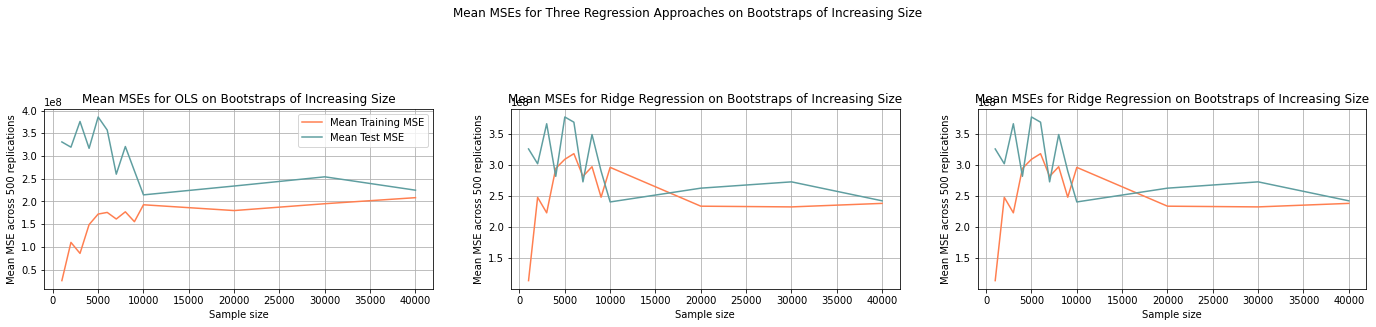

In [287]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
x_sampsize = olsmse[:,0]
y_trainmse = olsmse[:,1]
y_testmse = olsmse[:,2]
plt.plot(x_sampsize, y_trainmse, color = 'coral', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_testmse, color = 'cadetblue', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for OLS on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.legend()
plt.grid(True, which='both') 

plt.subplot(1,3,2)

x_sampsize = rmse[:,0]
y_trainmse = rmse[:,1]
y_testmse = rmse[:,2]
plt.plot(x_sampsize, y_trainmse, color = 'coral', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_testmse, color = 'cadetblue', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for Ridge Regression on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.grid(True, which='both')

plt.subplot(1,3,3) # YOUR CODE HERE

x_sampsize = lmse[:,0]
y_trainmse = lmse[:,1]
y_testmse = lmse[:,2]
plt.plot(x_sampsize, y_trainmse, color = 'coral', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_testmse, color = 'cadetblue', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for Ridge Regression on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.grid(True, which='both')

plt.suptitle('Mean MSEs for Three Regression Approaches on Bootstraps of Increasing Size')

plt.tight_layout(pad = 4)

plt.show()

In [276]:
ols_minsize = olsmse[olsmse[:,2] < 1.2 * 1.2 * ols_test_mse][0,0]
ridge_minsize = rmse[rmse[:,2] < 1.2 * 1.2 * r_test_mse][0,0]
lasso_minsize = lmse[lmse[:,2] < 1.2 * 1.2 * l_test_mse][0,0]

7000.0